# First attempt on a classifier discriminating top-W scattering and ttX

We are mostly concerned about other tt+X backgrounds (ttZ and ttH).

In [204]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [404]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

def getROC(signal=0):

    y_test_binary = (y_test_int!=signal)*0 + (y_test_int==signal)*1
    y_train_binary = (y_train_int!=signal)*0 + (y_train_int==signal)*1

    fpr_test, tpr_test, thresholds_test = roc_curve( y_test_binary, pred_test[:,signal] )
    auc_val_test = auc(fpr_test, tpr_test)

    plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))


    fpr_train, tpr_train, thresholds_test = roc_curve( y_train_binary, pred_train[:,signal]  )
    auc_val_train = auc(fpr_train, tpr_train)

    plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))

    plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
    plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
    plt.legend(loc ='lower left')


In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

## Binary classifier

In [3]:
df = pd.read_hdf('data/multiclass_input.h5') # load data processed with ML_processor.py

sig_df = df[df['label']==0]
bkg_df = df[df['label']>0]

# usually we have less signal than background
nSmall = len(sig_df) if len(sig_df) < len(bkg_df) else len(bkg_df)

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSmall )
tmp_sig_df = sig_df.sample( n = nSmall )

y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

print ("The smaller data set contains %s events"%nSmall)

# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.9*y_tmp.shape[0] ), random_state=42 )

variables = [
    'n_jet',
    'n_central',
    'n_fwd',
    'n_tau',
    'n_track',
    'st',
    'ht',
    'met',
    'mjj_max',
    'delta_eta_jj',
    'lead_lep_pt',
    'lead_lep_eta',
    'sublead_lep_pt',
    'sublead_lep_eta',
    'dilepton_mass',
    'dilepton_pt',
    'fwd_jet_pt',
    'fwd_jet_p',
    'fwd_jet_eta',
    'lead_jet_pt',
    'sublead_jet_pt',
]

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]

The smaller data set contains 71461 events


In [297]:
X_train = robust_scale(X_train, quantile_range=(10.0, 90.0))
X_test = robust_scale(X_test, quantile_range=(10.0, 90.0))

In [298]:
epochs = 50
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Dense(units=20, activation='relu', input_dim=X_train.shape[1], ))
model.add( tf.keras.layers.Dense(units=40, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )
model.add( tf.keras.layers.Dense(units=40, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )
model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 20)                440       
_________________________________________________________________
dense_86 (Dense)             (None, 40)                840       
_________________________________________________________________
dense_87 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 41        
Total params: 2,961
Trainable params: 2,961
Non-trainable params: 0
_________________________________________________________________


In [299]:
from ML.lrcurve import KerasLearningCurve

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    #validation_split=validation_split,
    verbose=0,
    callbacks=[KerasLearningCurve()]
)


In [300]:
#model.save( 'data/training.h5', include_optimizer=False )
model.save_weights( 'data/ttX_binary_weights.h5' )
model.save( 'data/ttX_binary_training.h5' )

Didn't find validation loss


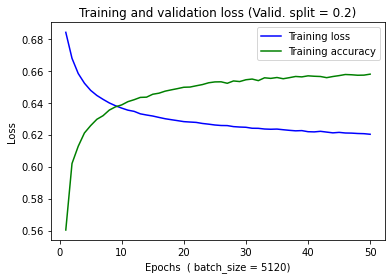

In [305]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)

plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

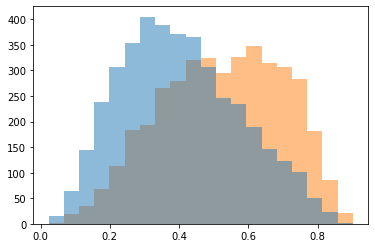

In [301]:
loaded_model = tf.keras.models.load_model('data/ttX_binary_training.h5')

# use the model to predict whether an event is signal or background
y_test_pred = loaded_model.predict( X_test  )

xbin = 20
hist, bins, ax = plt.hist( [ y_test_pred[y_test==0].flatten(), y_test_pred[y_test==1].flatten() ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

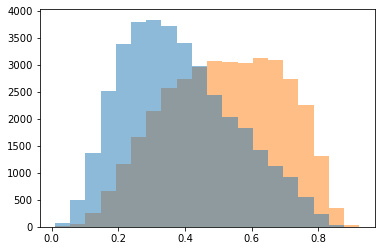

In [302]:
# use the model to predict whether an event is signal or background. this is with the training set
y_train_pred = loaded_model.predict( X_train )

xbin = 20
hist, bins, ax = plt.hist( [ y_train_pred[y_train==0].flatten(), y_train_pred[y_train==1].flatten() ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

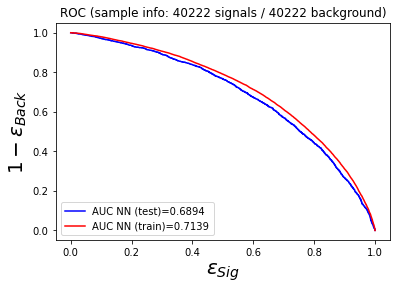

In [304]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))


fpr_train, tpr_train, thresholds_test = roc_curve( y_train, y_train_pred )
auc_val_train = auc(fpr_train, tpr_train)

plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))


plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')


In [14]:
means = pd.DataFrame(X_mean)
with open('data/means.json', 'w') as f:
    f.write(means.to_json())

# load the data frame and convert it to a series with squeeze
means = pd.read_json('data/means.json').squeeze()

stds = pd.DataFrame(X_std)
with open('data/stds.json', 'w') as f:
    f.write(stds.to_json())

# load the data frame and convert it to a series with squeeze
stds = pd.read_json('data/stds.json').squeeze()

# Multiclassifier

In [343]:
import copy

from keras.utils import np_utils
from sklearn.preprocessing import robust_scale

In [374]:
variables = [
    'n_jet',
    'n_central',
    'n_fwd',
    'n_tau',
    'n_track',
    'st',
    'ht',
    'met',
    'mjj_max',
    'delta_eta_jj',
    'lead_lep_pt',
    'lead_lep_eta',
    'sublead_lep_pt',
    'sublead_lep_eta',
    'dilepton_mass',
    'dilepton_pt',
    'fwd_jet_pt',
    'fwd_jet_p',
    'fwd_jet_eta',
    'lead_jet_pt',
    'sublead_jet_pt',
]

In [388]:
## filter some data
df = pd.read_hdf('data/multiclass_input.h5') # load data processed with ML_processor.py
#df = pd.read_hdf('data/multiclass_input.h5') # load data processed with ML_processor.py

#preselection = ((df['n_jet']>2) & (df['n_btag']>0)) # redundant selection, but we can filter on top
#
#df = df[preselection]

labels = df['label'].values

X = df[(labels<4)][variables]
labels = labels[labels<4]

In [389]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
encoder.fit(labels)
dummy_y = np_utils.to_categorical(labels)

dummy_y

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

### Normalize - I guess there's a lot of room for improvement

In [390]:


X_mean, X_std = X.mean(), X.std()

X_norm = copy.deepcopy(X)
X_norm -= X_mean
X_norm /= X_std

X_norm = np.nan_to_num(X_norm, 0) # this happens in like 10 events
X_norm

array([[-0.58671479, -0.55718763, -0.58932536, ..., -0.95360954,
        -0.34983492,  0.06724549],
       [ 0.71183894,  0.81054407, -0.58932536, ..., -1.21144463,
        -1.0281924 , -0.85752726],
       [ 0.71183894,  1.49440992, -0.58932536, ...,  0.78843485,
        -0.05549675, -0.09905136],
       ...,
       [ 0.71183894,  1.49440992, -0.58932536, ..., -0.83647874,
         2.07845492,  3.11940116],
       [-0.58671479, -0.55718763, -0.58932536, ...,  0.96855108,
         0.67459986,  1.14209101],
       [-1.23599166, -1.24105348, -0.58932536, ...,  1.14829897,
        -0.05319724, -0.41136497]])

What's written [in the docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.robust_scale.html) doesn't make any sense to me, unless your training and test set are really completely different samples that *should* follow a similar distribution. If, however, I expect a different distribution for a sample that I'm evaluating, I need to scale with the same parameters, otherwise all my features would be gone?!

In [391]:
X_norm = robust_scale(X, quantile_range=(10.0, 90.0))
X_norm

array([[-0.25      , -0.25      ,  0.        , ..., -0.67181797,
        -0.0440466 ,  0.15320403],
       [ 0.25      ,  0.25      ,  0.        , ..., -0.78053895,
        -0.37936914, -0.29462313],
       [ 0.25      ,  0.5       ,  0.        , ...,  0.06274753,
         0.10144928,  0.0726737 ],
       ...,
       [ 0.25      ,  0.5       ,  0.        , ..., -0.62242758,
         1.1562944 ,  1.63123005],
       [-0.25      , -0.25      ,  0.        , ...,  0.1386969 ,
         0.46234726,  0.67370489],
       [-0.5       , -0.5       ,  0.        , ...,  0.21449095,
         0.10258596, -0.07856617]])

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, dummy_y, train_size= int( 0.9*dummy_y.shape[0] ), random_state=42 )

In [393]:
input_dim = len(variables)
out_dim = len(dummy_y[0])

print (len(variables))

# define baseline model
def baseline_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(2*input_dim, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization() )
    model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization() )
    model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    #model.add(tf.keras.layers.Dense(50, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization() )
    #model.add(tf.keras.layers.Dense(50, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization() )
    #model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    #model.add(tf.keras.layers.Dense(40, activation='relu'))
    #model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    model.add(tf.keras.layers.Dense(out_dim, activation='softmax'))
    
    #opt = tf.keras.optimizers.SGD(lr=0.1)
    #opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    opt = tf.keras.optimizers.RMSprop(lr=0.001)
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'],
    )
    return model
 

model = baseline_model()
model.summary()
    


21
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 42)                924       
_________________________________________________________________
batch_normalization_26 (Batc (None, 42)                168       
_________________________________________________________________
dropout_26 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 50)                2150      
_________________________________________________________________
batch_normalization_27 (Batc (None, 50)                200       
_________________________________________________________________
dropout_27 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 4)            

In [394]:
np.unique(dummy_y, axis=0)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [395]:
from sklearn.utils import compute_class_weight

y_train_int = np.argmax(y_train, axis=1) # back to integers from one hot
y_test_int = np.argmax(y_test, axis=1) # back to integers from one hot

classWeight = compute_class_weight('balanced', classes=np.unique(y_train_int, axis=0), y=y_train_int) 
classWeight = dict(enumerate(classWeight))
classWeight

{0: 0.6748016490354698,
 1: 1.145277763109257,
 2: 0.9200994845470165,
 3: 1.7918146893588895}

In [396]:
from ML.lrcurve import KerasLearningCurve

epochs = 50
batch_size = 5120
#batch_size = 1000
validation_split = 0.2

history = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = validation_split,
    verbose = 0,
    class_weight = classWeight,
    callbacks = [KerasLearningCurve()]
)

In [397]:
pred_train = model.predict( X_train )
pred_test = model.predict( X_test )
pred_train

array([[0.15875873, 0.28616795, 0.17831765, 0.37675574],
       [0.452778  , 0.26035765, 0.18035139, 0.10651303],
       [0.33825192, 0.33412093, 0.17325315, 0.15437396],
       ...,
       [0.6354867 , 0.0391148 , 0.18317021, 0.14222823],
       [0.39251828, 0.13958131, 0.2505022 , 0.2173982 ],
       [0.08704413, 0.33162883, 0.16002552, 0.42130148]], dtype=float32)

In [356]:
X_all = df[variables].values
X_all -= X_mean
X_all /= X_std
pred_all = model.predict( X_all )
pred_all[:,0]

array([0.07019516, 0.21093006, 0.20950447, ..., 0.33220273, 0.12532404,
       0.4407784 ], dtype=float32)

In [357]:
df['score_topW'] = pred_all[:,0]
df['score_ttW'] = pred_all[:,1]
df['score_ttZ'] = pred_all[:,2]
df['score_ttH'] = pred_all[:,3]
df['score_ttbar'] = pred_all[:,4]
df['score_best'] = np.argmax(pred_all, axis=1)

In [334]:
def simpleAccuracy(pred, dummy_y):
    pred_Y = np.argmax(pred, axis=1)
    true_Y = np.argmax(dummy_y, axis=1)
    
    # this gives the measure of correctly tagged events, over the total
    return sum(pred_Y == true_Y)/len(true_Y)
    

In [398]:
simpleAccuracy(pred_train, y_train)

0.4401198812714331

In [399]:
simpleAccuracy(pred_test, y_test)

0.43695212407282535

In [400]:
simpleAccuracy(pred_train[y_train_int==2], y_train[y_train_int==2])

0.34906560889209426

In [401]:
simpleAccuracy(pred_test[y_test_int==2], y_test[y_test_int==2])

0.35741663472594865

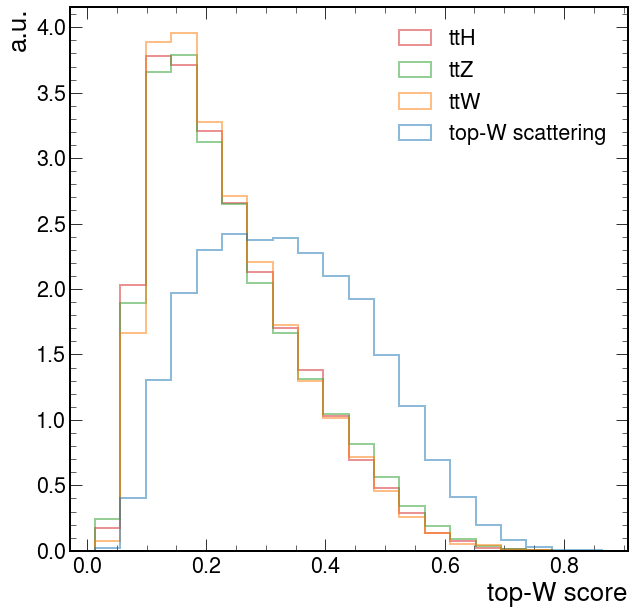

In [402]:
xbin = 20
hist, bins, ax = plt.hist(
    [
        pred_train[:,0][y_train_int==0],
        pred_train[:,0][y_train_int==1],
        pred_train[:,0][y_train_int==2],
        pred_train[:,0][y_train_int==3],
        #pred_train[:,0][y_train_int==4],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH', 'nonprompt'], histtype='step', linewidth=2, alpha=0.5, density=True) 

plt.xlabel('top-W score')
plt.ylabel('a.u.')
plt.legend()

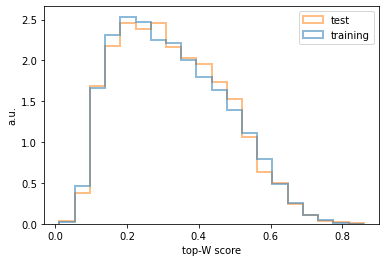

In [23]:
xbin = 20
hist, bins, ax = plt.hist(
    [ pred_train[:,0][y_train_int==0],
      pred_test[:,0][y_test_int==0],
    ], 
    xbin,
    log=False,
    label=['training' ,'test'], histtype='step', linewidth=2, alpha=0.5, density=True) 

plt.xlabel('top-W score')
plt.ylabel('a.u.')
plt.legend()

In [28]:
def getScore(signal=0):

    xbin = 20
    hist, bins, ax = plt.hist(
        [ pred_train[:,signal][(np.argmax(pred_train, axis=1)==signal) & (y_train_int==0)],
         pred_train[:,signal][(np.argmax(pred_train, axis=1)==signal) & (y_train_int==1)],
         pred_train[:,signal][(np.argmax(pred_train, axis=1)==signal) & (y_train_int==2)],
         pred_train[:,signal][(np.argmax(pred_train, axis=1)==signal) & (y_train_int==3)],
        ], 
        xbin,
        log=False,
        label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, alpha=0.5, density=True) 
    
    plt.xlabel('top-W score')
    plt.ylabel('a.u.')
    plt.legend()

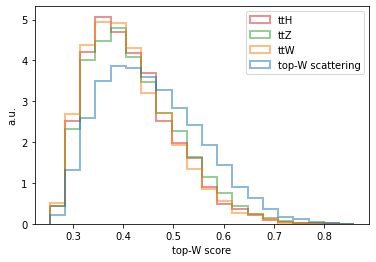

In [29]:
getScore(0)

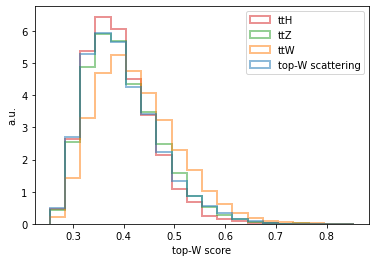

In [30]:
getScore(1)

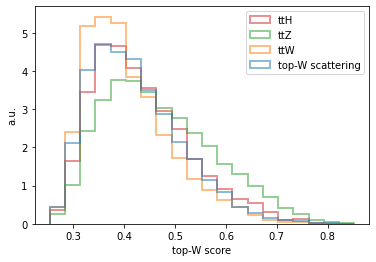

In [31]:
getScore(2)

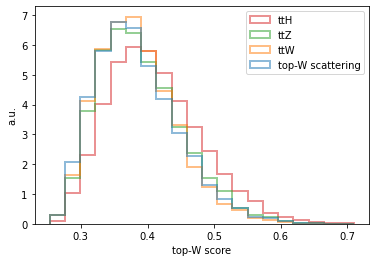

In [32]:
getScore(3)

In [368]:
xbin = 4
hist, bins, ax = plt.hist(
    [ np.argmax(pred, axis=1)[(labels==0)],
     np.argmax(pred, axis=1)[(labels==1)],
     np.argmax(pred, axis=1)[(labels==2)],
     np.argmax(pred, axis=1)[(labels==3)],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='stepfilled', linewidth=2, stacked=True) 

plt.xlabel('score')
plt.ylabel('events')
plt.legend()

NameError: name 'pred' is not defined

In [369]:
np.argmax(pred_nonprompt)

7634

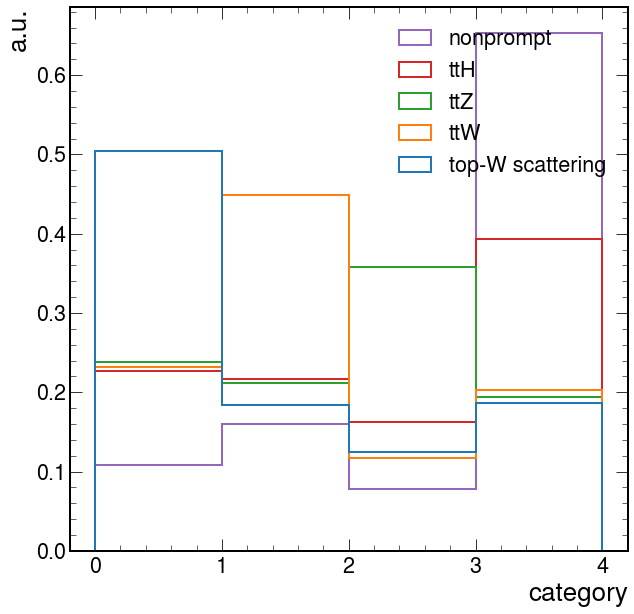

In [403]:
xbin = 4
hist, bins, ax = plt.hist(
    [
        np.argmax(pred_test, axis=1)[(y_test_int==0)],
        np.argmax(pred_test, axis=1)[(y_test_int==1)],
        np.argmax(pred_test, axis=1)[(y_test_int==2)],
        np.argmax(pred_test, axis=1)[(y_test_int==3)],
        np.argmax(pred_nonprompt, axis=1),
    ], 
    xbin,
    log=False,
    label=[
        'top-W scattering',
        'ttW',
        'ttZ',
        'ttH',
        'nonprompt',
    ], histtype='step', linewidth=2, density=True) 

plt.xlabel('category')
plt.ylabel('a.u.')
plt.legend()

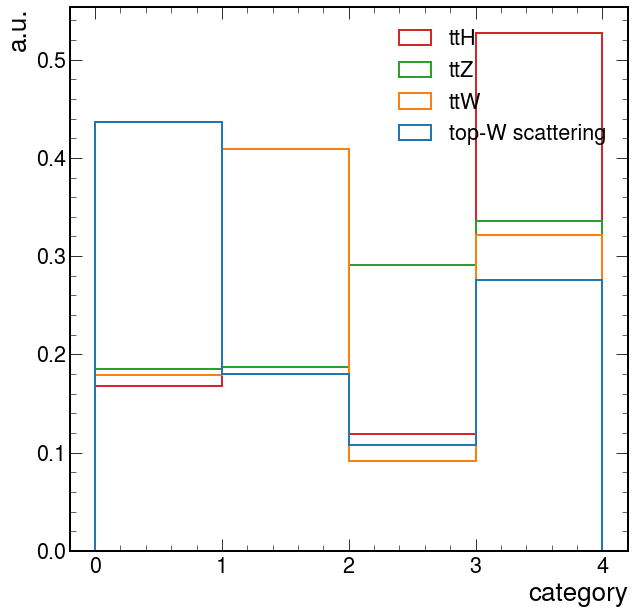

In [371]:
xbin = 4
hist, bins, ax = plt.hist(
    [ np.argmax(pred_train, axis=1)[(y_train_int==0)],
     np.argmax(pred_train, axis=1)[(y_train_int==1)],
     np.argmax(pred_train, axis=1)[(y_train_int==2)],
     np.argmax(pred_train, axis=1)[(y_train_int==3)],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, density=True) 

plt.xlabel('category')
plt.ylabel('a.u.')
plt.legend()

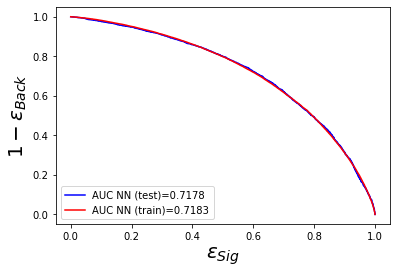

In [279]:
getROC(0)

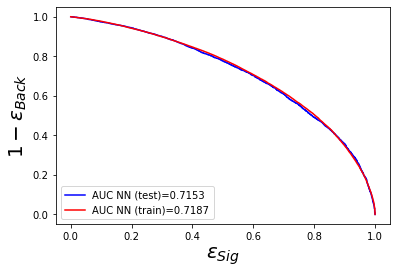

In [280]:
getROC(1)

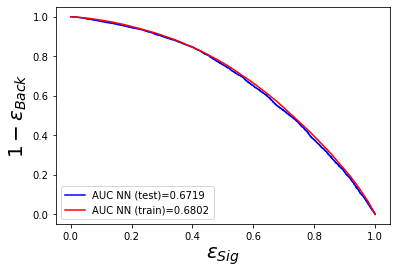

In [281]:
getROC(2)

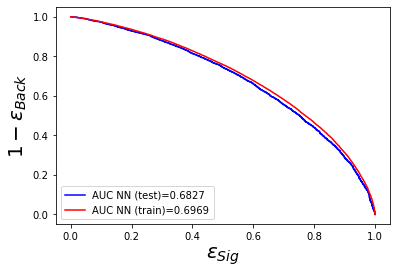

In [282]:
getROC(3)

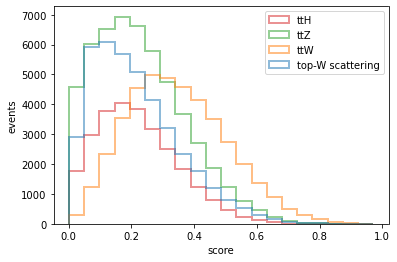

In [89]:
xbin = 20
hist, bins, ax = plt.hist(
    [ pred[:,1][labels==0],
     pred[:,1][labels==1],
     pred[:,1][labels==2],
     pred[:,1][labels==3],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, alpha=0.5) 

plt.xlabel('score')
plt.ylabel('events')
plt.legend()

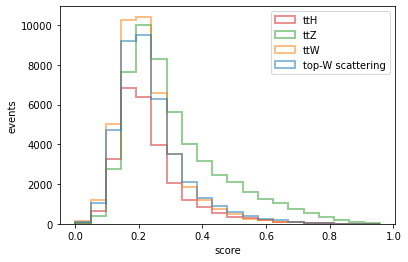

In [53]:
xbin = 20
hist, bins, ax = plt.hist(
    [ pred[:,2][labels==0],
     pred[:,2][labels==1],
     pred[:,2][labels==2],
     pred[:,2][labels==3],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, alpha=0.5) 

plt.xlabel('score')
plt.ylabel('events')
plt.legend()

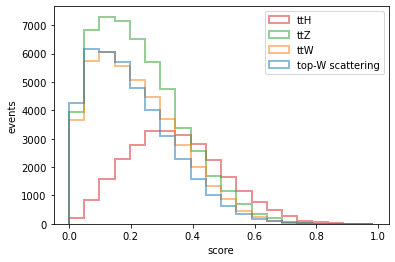

In [54]:
xbin = 20
hist, bins, ax = plt.hist(
    [ pred[:,3][labels==0],
     pred[:,3][labels==1],
     pred[:,3][labels==2],
     pred[:,3][labels==3],
    ], 
    xbin,
    log=False,
    label=['top-W scattering' ,'ttW', 'ttZ', 'ttH'], histtype='step', linewidth=2, alpha=0.5) 

plt.xlabel('score')
plt.ylabel('events')
plt.legend()

In [359]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from coffea import processor, hist
from processor.std_acumulators import *

from plots.helpers import *

score_axis              = hist.Bin("score",          r"N", 10, 0.25, 0.8)

N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
score_bins_coarse = hist.Bin('score', 'score', 10, 0, 1)
eta_bins = hist.Bin('eta', r'$\eta $', 50, -5.0, 5.0)


In [360]:
processes = {
    'topW_v2': df[df['label']==0],
    'TTW': df[df['label']==1],
    'TTZ': df[df['label']==2],
    'TTH': df[df['label']==3],
    'ttbar': df[df['label']==4],
}

sel_SR = ((df['n_jet']>4) & (df['n_central']>3) & (df['n_lep_tight']==2))
sel_topW = ((df['score_best']==0) & (df['n_jet']>4) & (df['n_central']>3))
sel_ttW = ((df['score_best']==1))
sel_ttZ = ((df['score_best']==2))
sel_ttH = ((df['score_best']==3))
sel_ttbar = ((df['score_best']==4))

h_best_score = hist.Hist("best_score", dataset_axis, multiplicity_axis)
h_score_topW = hist.Hist("score", dataset_axis, score_axis)
h_met_topW = hist.Hist("MET", dataset_axis, pt_axis)
h_met_ttW = hist.Hist("MET", dataset_axis, pt_axis)
h_met_ttZ = hist.Hist("MET", dataset_axis, pt_axis)
h_met_ttH = hist.Hist("MET", dataset_axis, pt_axis)

for proc in processes:
    h_best_score.fill(dataset=proc, multiplicity=processes[proc][sel_SR]['score_best'].values, weight=processes[proc][sel_SR]['weight'].values*60)
    h_score_topW.fill(dataset=proc, score=processes[proc][sel_topW]["score_topW"].values, weight=processes[proc][sel_topW]["weight"].values*60)
    h_met_topW.fill(dataset=proc, pt=processes[proc][sel_topW]["met"].values, weight=processes[proc][sel_topW]["weight"].values*60)
    h_met_ttW.fill(dataset=proc, pt=processes[proc][sel_ttW]["met"].values, weight=processes[proc][sel_ttW]["weight"].values*60)
    h_met_ttZ.fill(dataset=proc, pt=processes[proc][sel_ttZ]["met"].values, weight=processes[proc][sel_ttZ]["weight"].values*60)
    h_met_ttH.fill(dataset=proc, pt=processes[proc][sel_ttH]["met"].values, weight=processes[proc][sel_ttH]["weight"].values*60)

In [361]:
output = {
    'best_score': h_best_score,
    'score_topW': h_score_topW,
    'met_topW': h_met_topW,
    'met_ttW': h_met_ttW,
    'met_ttZ': h_met_ttZ,
    'met_ttH': h_met_ttH,
}


Data: 0 MC: 268.3


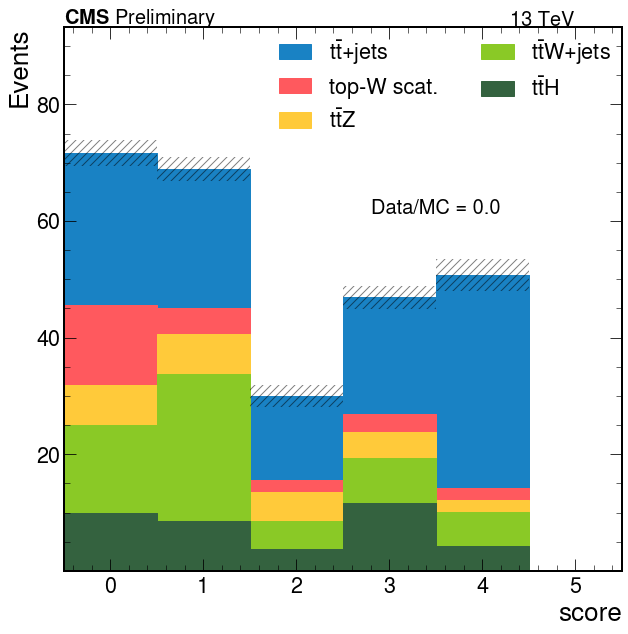

In [362]:
makePlot(output, 'best_score', 'multiplicity',
         data_sel=None, # use None if you don't use observation
         bins=N_bins_red, log=False, normalize=True, axis_label='score',
        )

Data: 0 MC: 268.3


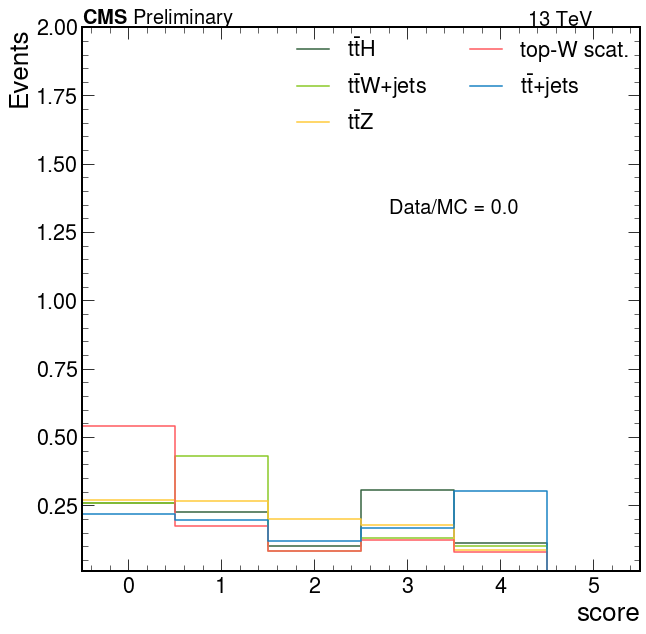

In [363]:
makePlot(output, 'best_score', 'multiplicity',
         data_sel=None, # use None if you don't use observation
         bins=N_bins_red, log=False, normalize=True, axis_label='score', shape=True,
        )

Data: 0 MC: 66.64


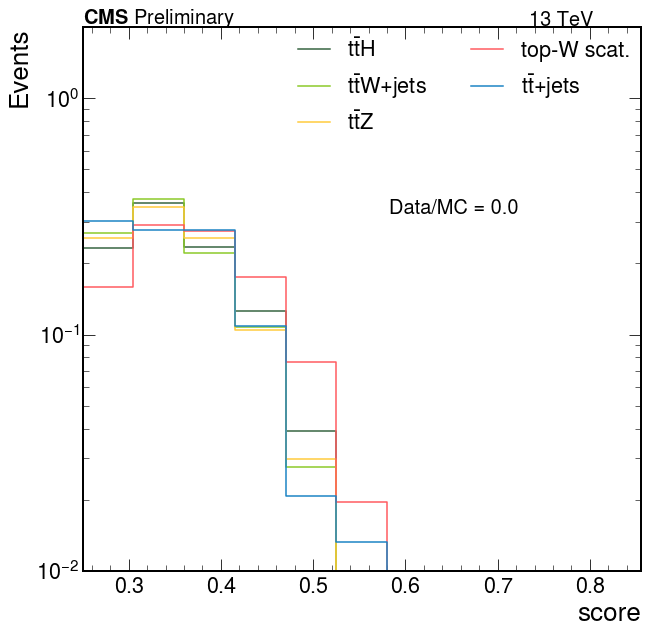

In [272]:
makePlot(output, 'score_topW', 'score',
         data_sel=None, # use None if you don't use observation
         bins=None, log=True, normalize=True, axis_label='score', shape=True,
        )

Data: 0 MC: 70.35


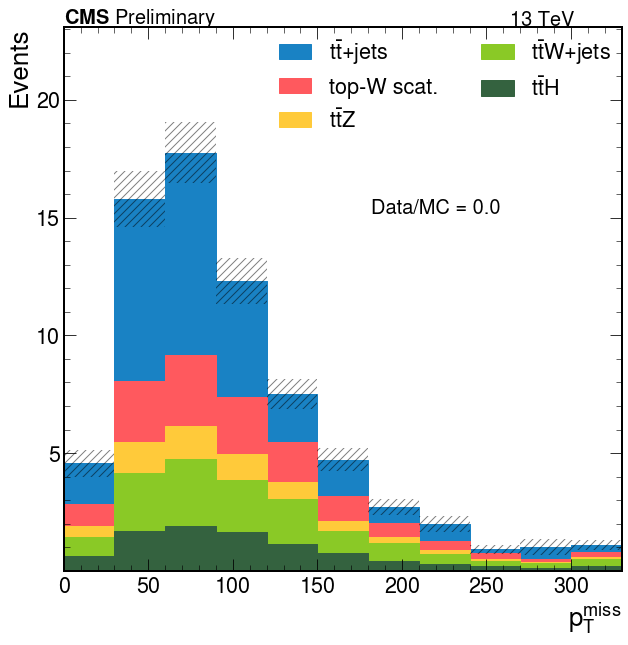

In [191]:
makePlot(output, 'met_topW', 'pt',
         data_sel=None, # use None if you don't use observation
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_T^{miss}$',
        )

Data: 0 MC: 138.25


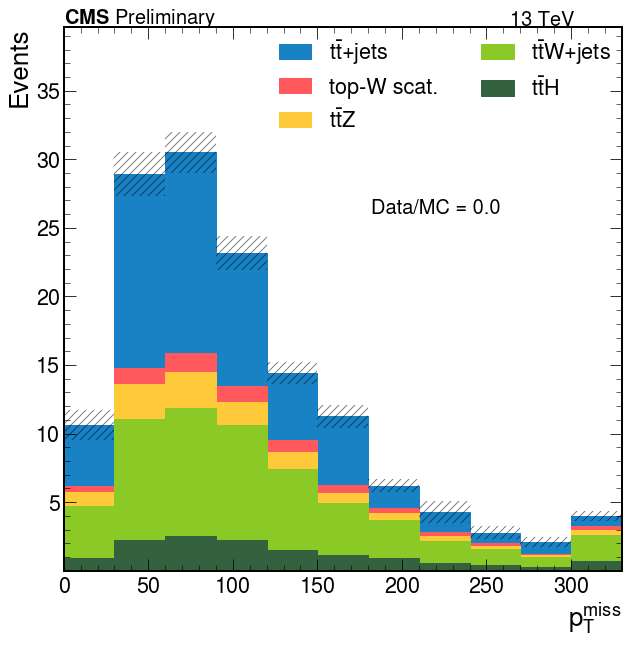

In [186]:
makePlot(output, 'met_ttW', 'pt',
         data_sel=None, # use None if you don't use observation
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_T^{miss}$',
        )

Data: 0 MC: 91.31


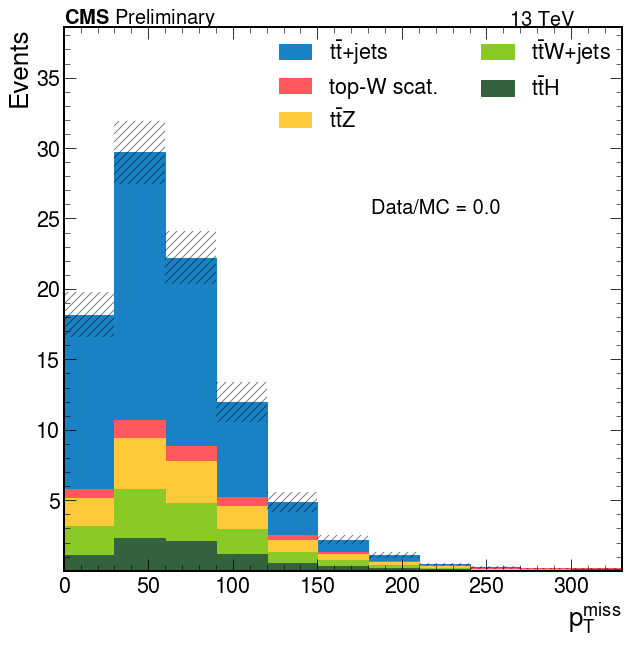

In [187]:
makePlot(output, 'met_ttZ', 'pt',
         data_sel=None, # use None if you don't use observation
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_T^{miss}$',
        )

Data: 0 MC: 91.31


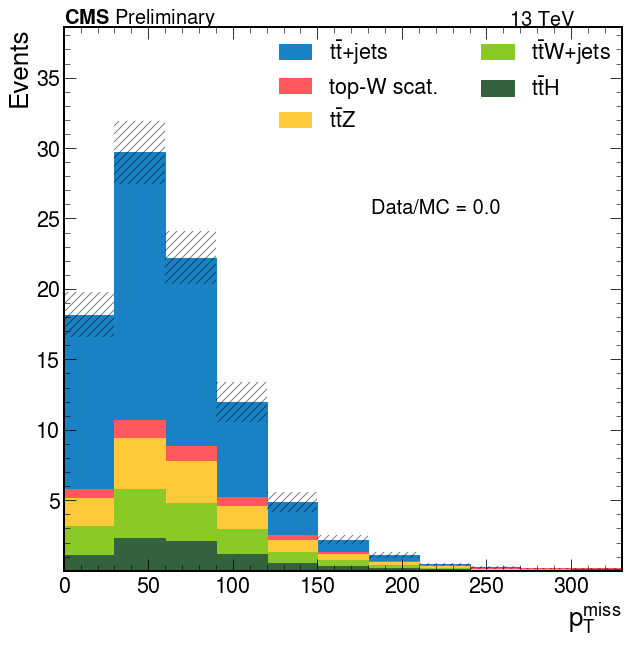

In [188]:
makePlot(output, 'met_ttH', 'pt',
         data_sel=None, # use None if you don't use observation
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_T^{miss}$',
        )

# BDT check

In [35]:
import xgboost as xgb

In [37]:
sig_df = df[df['label']==0]
bkg_df = df[df['label']>0]

# usually we have less signal than background
nSmall = len(sig_df) if len(sig_df) < len(bkg_df) else len(bkg_df)

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSmall )
tmp_sig_df = sig_df.sample( n = nSmall )

y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

print ("The smaller data set contains %s events"%nSmall)

# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.9*y_tmp.shape[0] ), random_state=42 )

variables = [
    'n_jet',
    'n_central',
    'n_fwd',
    'n_tau',
    'n_track',
    'st',
    'ht',
    'met',
    'mjj_max',
    'delta_eta_jj',
    'lead_lep_pt',
    'lead_lep_eta',
    'sublead_lep_pt',
    'sublead_lep_eta',
    'dilepton_mass',
    'dilepton_pt',
    'fwd_jet_pt',
    'fwd_jet_p',
    'fwd_jet_eta',
    'lead_jet_pt',
    'sublead_jet_pt',
]

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]

The smaller data set contains 40222 events


In [38]:
train = xgb.DMatrix(data=X_train,label=y_train,
                    missing=-999.0,feature_names=variables)
test = xgb.DMatrix(data=X_test,label=y_test,
                   missing=-999.0,feature_names=variables)

In [74]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 4  # maximum depth of a tree
#param['subsample']        = 0.8 # fraction of events to train tree on
#param['colsample_bytree'] = 0.8 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 100  # number of trees to make

In [75]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [76]:
print(booster.eval(test))

[0]	eval-error:0.347048	eval-logloss:0.626668	eval-rmse:0.467329


In [77]:
predictions = booster.predict(test)

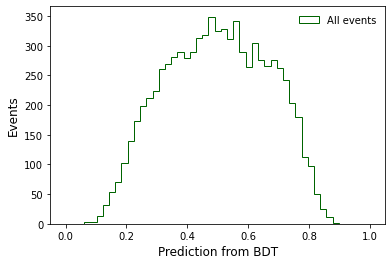

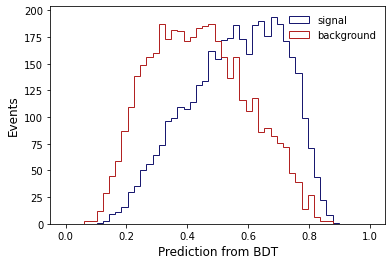

In [78]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

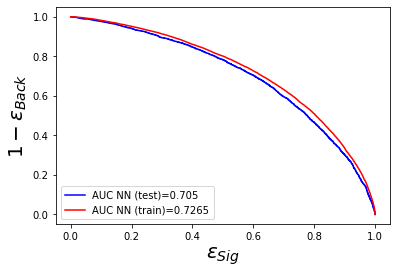

In [79]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, booster.predict(test) )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))


fpr_train, tpr_train, thresholds_test = roc_curve( y_train, booster.predict(train)  )
auc_val_train = auc(fpr_train, tpr_train)

plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))

plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')

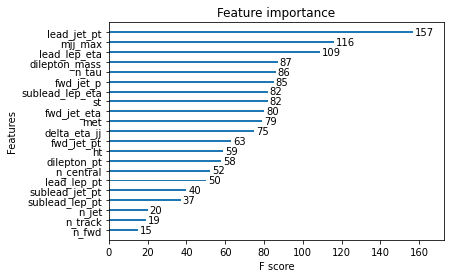

In [80]:
xgb.plot_importance(booster,grid=False);

## Multiclassifier example

[from here](https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/)